### Multi Head Attention
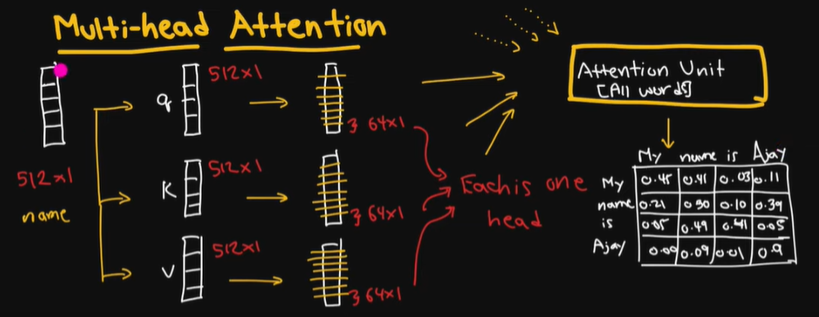

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [10]:
sequence_length = 4
batch_size = 1
input_dim = 512 # vector dimension of every word that will feed into the attention
d_model = 512 # output of attention unit for each single word
x = torch.randn( (batch_size, sequence_length, input_dim) ) 

In [11]:
x.size()

torch.Size([1, 4, 512])

In [12]:
qkv_layer = nn.Linear(input_dim, 3 * d_model) # 3 muliplication done for q, k, v

In [13]:
qkv = qkv_layer(x)

In [14]:
qkv.size()

torch.Size([1, 4, 1536])

In [18]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [19]:
qkv.size()

torch.Size([1, 4, 8, 192])

In [20]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]

In [22]:
qkv.size()

torch.Size([1, 8, 4, 192])

In [23]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [25]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.size()

torch.Size([1, 8, 4, 4])

In [28]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][0]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [35]:
(scaled + mask)[0][0]

tensor([[-0.0130,    -inf,    -inf,    -inf],
        [ 0.3671,  0.0984,    -inf,    -inf],
        [-0.2136, -0.2891, -0.1903,    -inf],
        [ 0.1682, -0.1799,  0.3249,  0.1746]], grad_fn=<SelectBackward0>)

In [31]:
scaled += mask

In [32]:
attention = F.softmax(scaled, dim=-1)

In [38]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5668, 0.4332, 0.0000, 0.0000],
        [0.3389, 0.3142, 0.3469, 0.0000],
        [0.2576, 0.1819, 0.3013, 0.2592]], grad_fn=<SelectBackward0>)

In [36]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [42]:
def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(d_k)
    if mask is not None:
        scaled = scaled + mask

    attention = F.softmax(scaled, dim=-1)
    out = torch.matmul(attention, v)
    return out, attention

In [43]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])